# 머신러닝

In [91]:
import pandas as pd
import numpy as np
import joblib
import time
import seaborn as sns
import re
from scipy.stats import *
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,  roc_auc_score, roc_curve,  precision_recall_curve, average_precision_score
from itertools import combinations
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import psutil
from tqdm import tqdm
from sklearn.calibration import calibration_curve

## 1. 티어별 포지션 게임 횟수를 고려한 챔피언 승률 예측 (회귀)

In [54]:
df_user_info = pd.read_csv('ranker_info_0205.csv')
df_champ_info = pd.read_csv('0205champ_list.csv')

### 1. 머신러닝용 데이터 전처리 및 병합

In [55]:
df_champ_info = df_champ_info.drop(columns=['Pick Rate', 'Ban Rate'])

In [56]:
df_champ_info['Win Rate'] = df_champ_info['Win Rate'].str.replace('%','')
df_champ_info['Play Count'] = df_champ_info['Play Count'].str.replace(',','')

df_champ_info['Win Rate'] = df_champ_info['Win Rate'].astype(float)
df_champ_info['Play Count'] = df_champ_info['Play Count'].astype(int)

In [57]:
df_champ_info['Lane'] = df_champ_info['Lane'].str.replace('바텀','원딜')

In [58]:
def extract_numbers(text):
    return "".join(re.findall(r"\d+", str(text))) 

df_user_info["게임횟수"] = df_user_info["게임횟수"].apply(extract_numbers)
df_user_info["승률"] = df_user_info["승률"].apply(extract_numbers)

df_user_info

,티어,닉네임,주챔피언,게임횟수,승률,포지션,포지션게임횟수
0,platinum,초현식근동이물 #KR1,제드,17,41,미드,27
1,platinum,매우라 #5838,아크샨,5,80,미드,6
2,platinum,Dancin #kr2,이즈리얼,4,75,원딜,7
3,platinum,Namy000n #5111,제드,10,80,미드,10
4,platinum,Fly over you #wing,빅토르,6,67,원딜,17
...,...,...,...,...,...,...,...
1194,challenger,Chu성훈 #KR1,카르마,52,60,서폿,146
1195,challenger,The Herta #Hokai,판테온,115,56,탑,129
1196,challenger,렝 화 #렝 화,렝가,95,59,탑,109
1197,challenger,kfo #KR1,블라디미르,259,56,탑,506


In [59]:
df_user_info['게임횟수'] = df_user_info['게임횟수'].astype(int)
df_user_info['승률'] = df_user_info['승률'].astype(int)

In [60]:
df_champ_info.rename(columns={'Tier': '티어', 'Champion Name': '주챔피언', 'Lane': '포지션', 'Win Rate': '챔피언 승률'}, inplace=True)

df_user_info['티어'] = df_user_info['티어'].str.title()
df_champ_info['티어'] = df_champ_info['티어'].str.title()

df_merge = df_user_info.merge(df_champ_info, on=['티어', '포지션', '주챔피언'], how='left')

df_merge['승률'] = df_merge[['승률', '챔피언 승률']].median(axis=1)

df_missing_champs = df_champ_info[~df_champ_info['주챔피언'].isin(df_user_info['주챔피언'])].copy()

df_missing_champs['포지션게임횟수'] = 0
df_missing_champs['승률'] = df_missing_champs['챔피언 승률']

df_missing_champs = df_missing_champs[['티어', '포지션', '주챔피언', '포지션게임횟수', '승률']]

df_merge = pd.concat([df_merge[['티어', '포지션', '주챔피언', '포지션게임횟수', '승률']], df_missing_champs], ignore_index=True)

df_merge

,티어,포지션,주챔피언,포지션게임횟수,승률
0,Platinum,미드,제드,27,44.660
1,Platinum,미드,아크샨,6,64.955
2,Platinum,원딜,이즈리얼,7,62.105
3,Platinum,미드,제드,10,64.160
4,Platinum,원딜,빅토르,17,67.000
...,...,...,...,...,...
1268,Master,정글,세주아니,0,46.190
1269,Master,서폿,밀리오,0,47.300
1270,Master,서폿,소나,0,45.580
1271,Master,탑,케일,0,46.570


In [61]:
df_merge[df_merge['주챔피언'] == '베인']

,티어,포지션,주챔피언,포지션게임횟수,승률
722,Master,원딜,베인,130,56.86


### 2. 데이터 레이블링 및 분리

In [62]:
label_encoder_tier = LabelEncoder()
label_encoder_position = LabelEncoder()
label_encoder_champion = LabelEncoder()

df_merge['티어_encode'] = label_encoder_tier.fit_transform(df_merge['티어'])
df_merge['포지션_encode'] = label_encoder_position.fit_transform(df_merge['포지션'])
df_merge['주챔피언_encode'] = label_encoder_champion.fit_transform(df_merge['주챔피언'])

In [63]:
Mapping1 = dict(zip(label_encoder_tier.classes_,range(len(label_encoder_tier.classes_))))
Mapping2 = dict(zip(label_encoder_position.classes_,range(len(label_encoder_position.classes_))))
Mapping3 = dict(zip(label_encoder_champion.classes_,range(len(label_encoder_champion.classes_))))
print(f'{Mapping1}')
print(f'{Mapping2}')
print(f'{Mapping3}')

{'Challenger': 0, 'Diamond': 1, 'Emerald': 2, 'Grandmaster': 3, 'Master': 4, 'Platinum': 5}
{'미드': 0, '서폿': 1, '원딜': 2, '정글': 3, '탑': 4}
{'가렌': 0, '갈리오': 1, '갱플랭크': 2, '그라가스': 3, '그레이브즈': 4, '그웬': 5, '나르': 6, '나미': 7, '나서스': 8, '나피리': 9, '노틸러스': 10, '녹턴': 11, '누누와 윌럼프': 12, '니달리': 13, '니코': 14, '닐라': 15, '다리우스': 16, '다이애나': 17, '드레이븐': 18, '라이즈': 19, '라칸': 20, '람머스': 21, '럭스': 22, '럼블': 23, '레나타 글라스크': 24, '레넥톤': 25, '레오나': 26, '렉사이': 27, '렐': 28, '렝가': 29, '루시안': 30, '룰루': 31, '르블랑': 32, '리 신': 33, '리븐': 34, '리산드라': 35, '릴리아': 36, '마스터 이': 37, '마오카이': 38, '말자하': 39, '말파이트': 40, '멜': 41, '모데카이저': 42, '모르가나': 43, '문도 박사': 44, '미스 포츈': 45, '밀리오': 46, '바드': 47, '바루스': 48, '바이': 49, '베이가': 50, '베인': 51, '벡스': 52, '벨베스': 53, '벨코즈': 54, '볼리베어': 55, '브라움': 56, '브라이어': 57, '브랜드': 58, '블라디미르': 59, '블리츠크랭크': 60, '비에고': 61, '빅토르': 62, '뽀삐': 63, '사미라': 64, '사이온': 65, '사일러스': 66, '샤코': 67, '세나': 68, '세라핀': 69, '세주아니': 70, '세트': 71, '소나': 72, '소라카': 73, '쉔': 74, '쉬바나': 75, '스몰더': 76, '스웨인': 77, '스카너

In [64]:
X = df_merge[['티어_encode', '포지션_encode','주챔피언_encode', '포지션게임횟수']]
y = df_merge['승률']

print(f'독립변수크기: {X.shape}')
print(f'종속변수크기: {y.shape}')

독립변수크기: (1273, 4)
종속변수크기: (1273,)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=13)

print(f'학습데이터 크기 : {X_train.shape}')
print(f'검증데이터 크기 : {X_test.shape}')

학습데이터 크기 : (1018, 4)
검증데이터 크기 : (255, 4)


### 3. 최적의 알고리즘 찾기

In [66]:
R_forest = RandomForestRegressor(random_state=13)
XG_Boost = XGBRegressor(random_state = 13)
S_reg = SVR()


R_forest.fit(X_train, y_train)
R_pred = R_forest.predict(X_test)


XG_Boost.fit(X_train, y_train)
X_pred = XG_Boost.predict(X_test)


S_reg.fit(X_train, y_train)
S_pred = S_reg.predict(X_test)


models = {'랜덤포레스트': R_pred, 'XGBoost': X_pred, 'SVR': S_pred}

for name, pred in models.items():
    print(f"\n{name} 성능 평가:")
    print(f" - MAE: {mean_absolute_error(y_test, pred):.4f}")
    print(f" - MSE: {mean_squared_error(y_test, pred):.4f}")
    print(f" - R² Score: {r2_score(y_test, pred):.4f}")


랜덤포레스트 성능 평가:
 - MAE: 6.3073
 - MSE: 76.0706
 - R² Score: -0.0005

XGBoost 성능 평가:
 - MAE: 6.7842
 - MSE: 90.1458
 - R² Score: -0.1856

SVR 성능 평가:
 - MAE: 6.5352
 - MSE: 76.0981
 - R² Score: -0.0008


- MAE : 값이 작을수록 모델의 예측 오차가 적음 <br>
XGBOOST > SVR > 랜덤포레스트 <br>
- MSE : 값이 작을수록 실제 값과 예측 값의 차이가 적음 <br>
XGBOOST > SVR > 랜덤포레스트 <br>
- R2 : 1에 가까울수록 성능이 좋음 <br>
1 > 랜덤포레스트 > SVR > XGBOOST <br>
<br>
- 최적의 알고리즘 : 랜덤포레스트

### 4. 최적의 파라미터 찾기

In [67]:
model = RandomForestRegressor(n_estimators=100,
                              max_depth=None,
                              random_state=13)

model.fit(X_train,y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [68]:
y_pred = model.predict(X_test)
y_pred

array([55.1798    , 51.96      , 59.68585   , 70.69      , 59.48775   ,
       66.433     , 60.134     , 56.75965   , 55.51305   , 56.1473    ,
       62.6792    , 58.001     , 56.3133    , 48.8401    , 58.56485   ,
       55.94295   , 53.5778    , 51.93605   , 53.8556    , 50.9673    ,
       59.1192    , 57.125     , 62.276     , 61.1314    , 60.14895   ,
       62.29      , 51.2184    , 49.40625   , 54.7822    , 49.5505    ,
       64.10125   , 52.0532    , 50.1182    , 54.54035   , 51.48955   ,
       56.87      , 54.66165   , 59.84      , 51.5704    , 49.9258    ,
       55.51945   , 55.28665   , 56.8762    , 56.42995   , 49.4577    ,
       55.61375   , 59.11195   , 54.7607    , 54.03785   , 53.1282    ,
       60.11721667, 54.5255    , 56.5562    , 55.26015   , 62.53606667,
       59.02695   , 57.64      , 56.53935   , 51.91      , 55.5827    ,
       52.9793    , 59.3372    , 58.91705   , 63.61643095, 55.899     ,
       53.4351    , 53.6456    , 67.44      , 52.2724    , 42.86

In [69]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'r2: {r2}')

MSE: 76.07058034770141
MAE: 6.307342455507457
RMSE: 8.721845008236583
r2: -0.0004535048202891634


In [70]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [71]:
best_params = grid_search.best_params_
model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                              max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'],
                              min_samples_leaf=best_params['min_samples_leaf'],
                              random_state=13)

model.fit(X_train,y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
y_pred2 = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
mae = mean_absolute_error(y_test, y_pred2)
rmse = np.sqrt(mean_squared_error(y_test,y_pred2))
r2 = r2_score(y_test, y_pred2)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'r2: {r2}')

MSE: 64.07808755079814
MAE: 5.631451437526915
RMSE: 8.004878984144492
r2: 0.1572675404951812


- 하이퍼파라미터 튜닝 전 후 비교 <br>

||튜닝 전|튜닝 후|
|-|-|-|
|MSE|76.07|64.07|
|MAE|6.30|5.63|
|RMSE|8.72|8.00|
|r2|-0.0004|0.1572|

### 5. 변수 중요도 시각화

Text(0, 0.5, 'importance score')

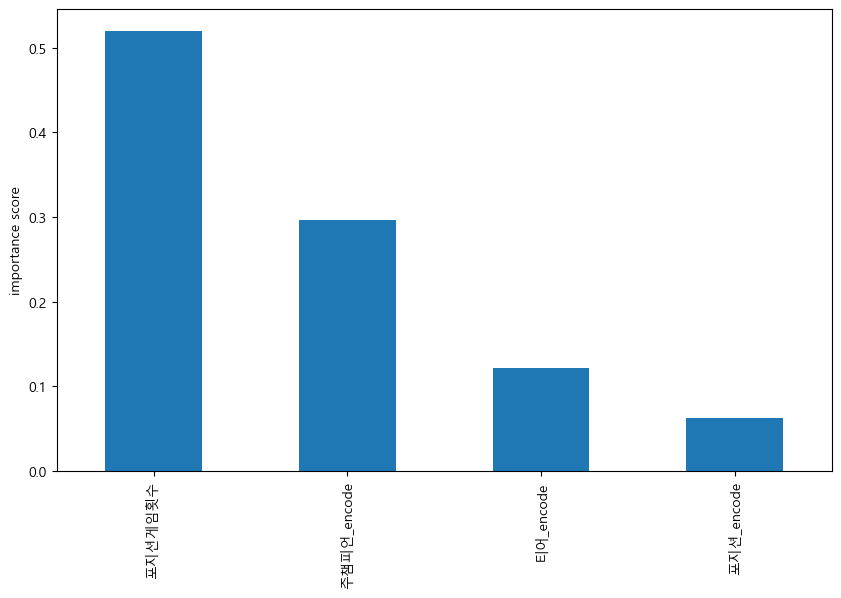

In [22]:
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

feature_importances = pd.Series(model.feature_importances_,index=X.columns)

feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))


plt.ylabel('importance score')

### 6. 결과

#### - 실제값과 예측값 비교

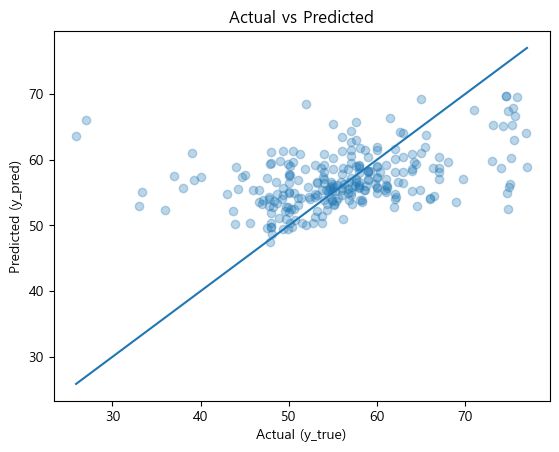

In [73]:
plt.figure()
plt.scatter(y_test, y_pred2, alpha=0.3)
mn = min(y_test.min(), y_pred2.min())
mx = max(y_test.max(), y_pred2.max())
plt.plot([mn, mx], [mn, mx])  # y=x 기준선
plt.xlabel("Actual (y_true)")
plt.ylabel("Predicted (y_pred)")
plt.title("Actual vs Predicted")
plt.show()

#### - 잔차패턴

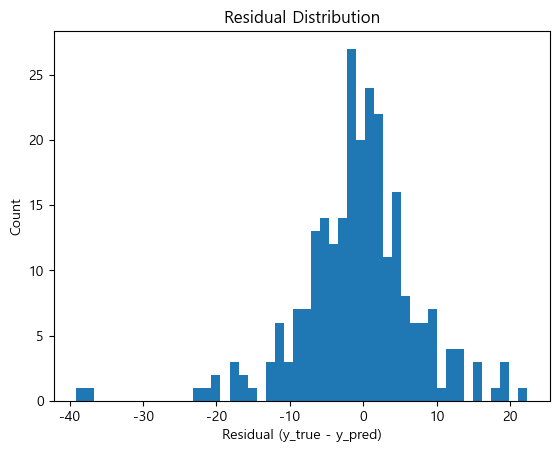

In [74]:
residual = y_test - y_pred2
# 잔차 히스토그램
plt.figure()
plt.hist(residual, bins=50)
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()


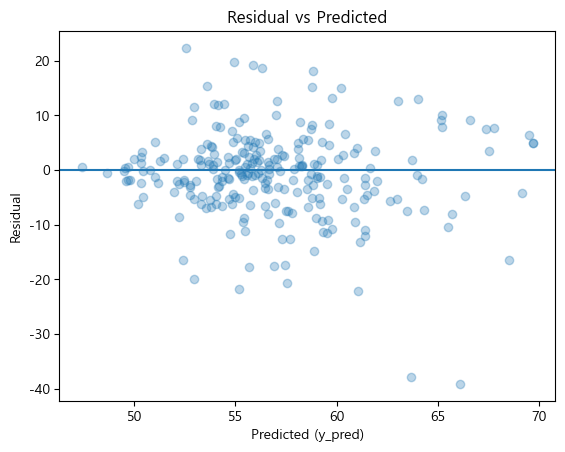

In [75]:
# 예측값에 따른 잔차(패턴 확인)
plt.figure()
plt.scatter(y_pred2, residual, alpha=0.3)
plt.axhline(0)
plt.xlabel("Predicted (y_pred)")
plt.ylabel("Residual")
plt.title("Residual vs Predicted")
plt.show()

## 2. 챔피언 조합 기반 승률 예측 (회귀)

### 1. 머신러닝용 데이터 전처리

In [23]:
df_combi = pd.read_csv('match_combination.csv')

In [24]:
df_combi = df_combi.drop(columns='matchID')

In [25]:
df_combi

,TOP,JUNGLE,MID,BOTTOM,SUPPORT,승패
0,럼블,헤카림,사일러스,자야,쓰레쉬,0
1,렝가,리 신,아리,징크스,모르가나,1
2,세주아니,리 신,알리스타,드레이븐,룰루,1
3,잭스,럼블,제드,자야,모르가나,0
4,탐 켄치,케인,아리,야스오,신드라,0
...,...,...,...,...,...,...
169755,멜,케인,미스 포츈,루시안,유미,0
169756,카르마,벨베스,탈리야,이즈리얼,조이,1
169757,크산테,킨드레드,카시오페아,드레이븐,룰루,0
169758,이렐리아,다이애나,빅토르,트리스타나,블리츠크랭크,1


In [26]:
df_combi.shape

(169760, 6)

### 2. 챔피언간 시너지 (상호작용 변수) 계산

In [27]:
def create_synergy_features(df):
   
    synergy_features = set()
    
    for _, row in df.iterrows():
        champions = [row["TOP"], row["JUNGLE"], row["MID"], row["BOTTOM"], row["SUPPORT"]]
        for champ1, champ2 in combinations(champions, 2):
            synergy_features.add(f"synergy_{champ1}_{champ2}")

    
    synergy_features = sorted(synergy_features)  
    feature_index_map = {feature: idx for idx, feature in enumerate(synergy_features)}

    
    num_rows = len(df)
    num_features = len(synergy_features)
    synergy_matrix = np.zeros((num_rows, num_features), dtype=np.uint8)  

    
    for i, row in enumerate(df.itertuples(index=False)):
        champions = [row.TOP, row.JUNGLE, row.MID, row.BOTTOM, row.SUPPORT]
        for champ1, champ2 in combinations(champions, 2):
            feature_name = f"synergy_{champ1}_{champ2}"
            synergy_matrix[i, feature_index_map[feature_name]] = 1  

    # 
    synergy_df = pd.DataFrame(synergy_matrix, columns=synergy_features)
    df = pd.concat([df, synergy_df], axis=1)

    return df

df = create_synergy_features(df_combi)

In [28]:
df.head()

,TOP,JUNGLE,MID,BOTTOM,SUPPORT,승패,synergy_가렌_갈리오,synergy_가렌_갱플랭크,synergy_가렌_그라가스,synergy_가렌_그레이브즈,...,synergy_흐웨이_트리스타나,synergy_흐웨이_트위스티드 페이트,synergy_흐웨이_트위치,synergy_흐웨이_티모,synergy_흐웨이_파이크,synergy_흐웨이_판테온,synergy_흐웨이_피들스틱,synergy_흐웨이_피오라,synergy_흐웨이_하이머딩거,synergy_흐웨이_헤카림
0,럼블,헤카림,사일러스,자야,쓰레쉬,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,렝가,리 신,아리,징크스,모르가나,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,세주아니,리 신,알리스타,드레이븐,룰루,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,잭스,럼블,제드,자야,모르가나,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,탐 켄치,케인,아리,야스오,신드라,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3. PCA(차원 축소)

In [29]:
synergy_columns = [col for col in df.columns if col.startswith("synergy_")]
synergy_data = df[synergy_columns]

synergy_sparse = csr_matrix(synergy_data.values)

scaler = StandardScaler(with_mean=False)
synergy_scaled = scaler.fit_transform(synergy_sparse)

svd = TruncatedSVD(n_components=100)
synergy_svd = svd.fit_transform(synergy_scaled)

pca_columns = [f"pca_{i+1}" for i in range(synergy_svd.shape[1])]
df_pca = pd.DataFrame(synergy_svd, columns=pca_columns)

df_reduced = df.drop(columns=synergy_columns).reset_index(drop=True)
df_reduced = pd.concat([df_reduced, df_pca], axis=1)

df_reduced

,TOP,JUNGLE,MID,BOTTOM,SUPPORT,승패,pca_1,pca_2,pca_3,pca_4,...,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100
0,럼블,헤카림,사일러스,자야,쓰레쉬,0,3.161183,0.317863,-0.112291,0.008475,...,1.131841,1.810129,0.655325,-1.331747,0.740627,0.118710,0.267151,-0.955989,1.322557,-0.913191
1,렝가,리 신,아리,징크스,모르가나,1,3.171169,0.494433,-0.428155,2.040835,...,-0.943306,2.397579,1.922280,4.816271,1.560714,-0.713086,3.320071,-0.255160,1.861537,0.272289
2,세주아니,리 신,알리스타,드레이븐,룰루,1,3.181089,-0.326651,-2.333021,2.684991,...,14.997596,-0.199563,-7.795501,-9.254608,0.812087,-6.091887,4.939762,4.975637,10.177756,-2.317132
3,잭스,럼블,제드,자야,모르가나,0,3.157851,0.254609,-0.088496,0.114904,...,-2.729714,0.085775,0.508656,3.288619,1.202087,0.801658,2.588243,0.138291,1.137293,-0.736907
4,탐 켄치,케인,아리,야스오,신드라,0,3.158188,-0.116465,-0.215941,3.238951,...,0.478409,-5.805089,0.479386,1.179025,4.918853,-1.404026,-2.575314,1.645381,-0.332325,4.130786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169755,멜,케인,미스 포츈,루시안,유미,0,3.152706,-0.435997,1.852749,8.902566,...,2.557577,1.004445,-1.217426,-1.406364,0.504733,0.570456,-2.695219,-0.866359,0.993773,2.375221
169756,카르마,벨베스,탈리야,이즈리얼,조이,1,3.153631,-0.001538,-0.237770,-1.717782,...,1.862448,-1.417347,2.072394,1.102049,2.123509,-0.705126,0.627496,1.377151,1.569566,0.370402
169757,크산테,킨드레드,카시오페아,드레이븐,룰루,0,3.158380,0.307155,0.043262,1.217586,...,0.844720,-0.509468,-1.680596,-0.216222,-1.693000,2.247544,-1.993551,-0.201445,-2.598076,-1.500703
169758,이렐리아,다이애나,빅토르,트리스타나,블리츠크랭크,1,3.166789,0.020635,0.333897,0.232021,...,0.572611,-2.710135,2.897245,-0.241815,0.038407,-1.260870,-1.992769,0.141934,-0.217090,-1.923671


### 4. 최적의 알고리즘 찾기

In [76]:
X = df_reduced.drop(columns=["승패", "TOP", "JUNGLE", "MID", "BOTTOM", "SUPPORT"])
y = df_reduced["승패"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = GradientBoostingRegressor(n_estimators=100, random_state=42)
result = []


models.fit(X_train, y_train)
y_pred = models.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

result.append({"Model": 'g', "검증 R² Score": r2_test, "검증RMSE": rmse_test})

df_results = pd.DataFrame(result)

In [43]:
models = XGBRegressor(random_state=42)
result = []

models.fit(X_train, y_train)
y_pred = models.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

result.append({"Model": 'xgboost', "검증 R² Score": r2_test, "검증RMSE": rmse_test})

df_results_xg = pd.DataFrame(result)

In [44]:
models = RandomForestRegressor(random_state=42)
result = []
models.fit(X_train, y_train)
y_pred = models.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

result.append({"Model": 'random', "검증 R² Score": r2_test, "검증RMSE": rmse_test})

df_results_random = pd.DataFrame(result)

In [45]:
models = KNeighborsRegressor()
result = []
models.fit(X_train, y_train)
y_pred = models.predict(X_test)

r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

result.append({"Model": 'knn', "검증 R² Score": r2_test, "검증RMSE": rmse_test})

df_results_knn = pd.DataFrame(result)

In [38]:
df_results_xg

,Model,검증 R² Score,검증RMSE
0,xgboost,-0.036229,0.508975


In [40]:
df_results_random

,Model,검증 R² Score,검증RMSE
0,xgboost,-0.036229,0.508975
1,gradient,0.000016,0.499994
2,gradient,-0.019574,0.504868


In [41]:
df_results_knn

,Model,검증 R² Score,검증RMSE
0,xgboost,-0.036229,0.508975
1,gradient,0.000016,0.499994
2,gradient,-0.019574,0.504868
3,gradient,-0.190795,0.545616


In [46]:
import pandas as pd

df_results = pd.concat([df_results_xg, df_results, df_results_random, df_results_knn], ignore_index=True)
df_results

,Model,검증 R² Score,검증RMSE
0,xgboost,-0.036229,0.508975
1,g,0.000016,0.499994
2,random,-0.019574,0.504868
3,knn,-0.190795,0.545616


- 여러 알고리즘을 시도해본 결과, Gradient Boost 회귀의 정확도가 가장 높다.

### 5. 최적의 파라미터 찾기

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],   # 트리 개수
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 학습률
    'max_depth': [3, 5, 7],  # 트리의 깊이
    'subsample': [0.7, 0.8, 0.9, 1.0],  # 샘플링 비율
    'min_samples_split': [2, 5, 10],  # 내부 노드를 나누는 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]  # 리프 노드의 최소 샘플 수
}
# 모델 초기화
gbr = GradientBoostingRegressor(random_state=42)

# GridSearchCV 적용
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # RMSE를 최소화
    n_jobs=-1,  # 병렬 처리
    verbose=2  # 진행 상태 출력
)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최적 성능 (MSE):", -grid_search.best_score_)


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time= 9.2min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time= 9.2min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time= 9.2min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time= 9.3min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time= 9.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=10.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total tim

KeyboardInterrupt: 

- GridSearchCV로 최적의 파라미터를 찾는 중, 약 7일이 지나도 끝나지 않음
- 경우의 수가 너무 많아 오래 걸리는 것으로 파악
- RandomsizedSearchCV로 변경
- CPU 사용 85%로 제한
- 폴드 3개로 축소
- 진행률을 표기하는 tqdm 사용

In [ ]:
import time
import psutil
from tqdm.auto import tqdm
import joblib
from contextlib import contextmanager

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV


@contextmanager
def tqdm_joblib(tqdm_object):
    """joblib 병렬 작업 완료될 때마다 tqdm 업데이트"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()



param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

total_cores = psutil.cpu_count(logical=True)
cpu_limit = int(total_cores * 0.85)
cpu_limit = max(cpu_limit, 1)

print(f"사용 가능한 총 코어: {total_cores}, 85% 사용 시: {cpu_limit}개")

gbr = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=300,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=cpu_limit,
    verbose=0,                
    pre_dispatch="2*n_jobs"    
)

total_iter = random_search.n_iter * random_search.cv 
start_time = time.time()

with tqdm_joblib(tqdm(total=total_iter, desc="RandomizedSearch 진행 중", unit="fit")):
    random_search.fit(X_train, y_train)

elapsed_time = (time.time() - start_time) / 60
print(f" 완료! 총 소요 시간: {elapsed_time:.2f}분")
print(" 최적의 하이퍼파라미터:", random_search.best_params_)
print(" 최적 성능 (MSE):", -random_search.best_score_)


사용 가능한 총 코어: 12, 85% 사용 시: 10개


RandomizedSearch 진행 중:   0%|          | 0/900 [00:00<?, ?fit/s]

 완료! 총 소요 시간: 3254.66분
 최적의 하이퍼파라미터: {'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.01}
 최적 성능 (MSE): 0.24981090468575817


- 도출된 최적의 파라미터로 모델 학습

In [77]:
best_params = random_search.best_params_
model = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],
                                  max_depth = best_params['max_depth'],
                                  min_samples_split = best_params['min_samples_split'],
                                  min_samples_leaf = best_params['min_samples_leaf'],
                                  learning_rate = best_params['learning_rate'],
                                  subsample = best_params['subsample'])
model.fit(X_train,y_train)

,loss,'squared_error'
,learning_rate,0.01
,n_estimators,300
,subsample,0.7
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [78]:
Y_pred_2 = model.predict(X_test)
mse = mean_squared_error(y_test, Y_pred_2)
mae = mean_absolute_error(y_test, Y_pred_2)
rmse = np.sqrt(mean_squared_error(y_test, Y_pred_2))
r2 = r2_score(y_test, Y_pred_2)

print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE : {rmse}')
print(f'r2 : {r2}')

MSE : 0.24983774043548207
MAE : 0.4996324907744661
RMSE : 0.4998377140987683
r2 : 0.0006423246563712626


- 하이퍼파라미터 튜닝 전 후 비교 <br>

||튜닝 전|튜닝 후|
|-|-|-|
|MSE|0.24|0.24|
|MAE|0.49|0.49|
|RMSE|0.49|0.49|
|r2|0.0004|0.0006|

### 6. 변수 중요도 시각화

Text(0, 0.5, 'importance score')

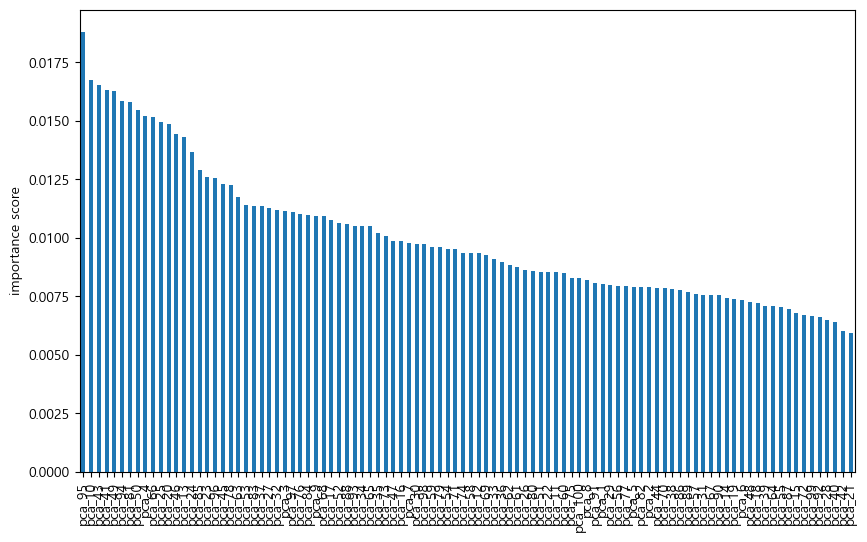

In [51]:
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

feature_importances = pd.Series(model.feature_importances_,index=X.columns)

feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))


plt.ylabel('importance score')

#### 7. 결론

In [ ]:
if hasattr(model, "predict_proba"):
    y_score = model.predict_proba(X_test)[:, 1]   # 양성
elif hasattr(model, "decision_function"):
    y_score = model.decision_function(X_test)     # 점수
else:
    # 회귀 모델로 0~1 값이 나오는 경우
    y_score = model.predict(X_test)

print(y_score)

[0.49710772 0.49584888 0.48207356 ... 0.50835733 0.48864501 0.49226655]


In [81]:
y_pred_2 = (y_score >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_2)
f1  = f1_score(y_test, y_pred_2)

print(f"[Model2] ACC={acc:.4f} | F1={f1:.4f}")

[Model2] ACC=0.5118 | F1=0.5186


<Figure size 640x480 with 0 Axes>

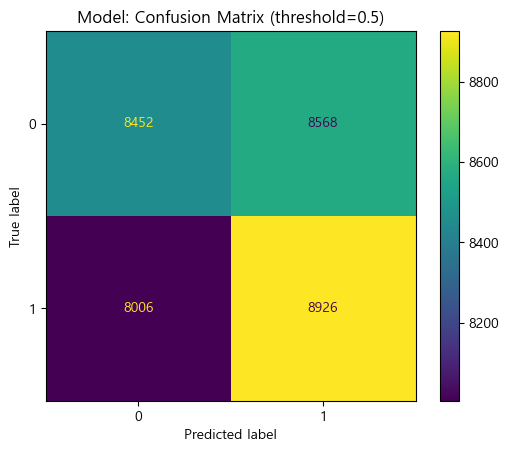

In [ ]:
# 3) 혼동행렬
cm = confusion_matrix(y_test, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure()
disp.plot()
plt.title("Model: Confusion Matrix (threshold=0.5)")
plt.show()

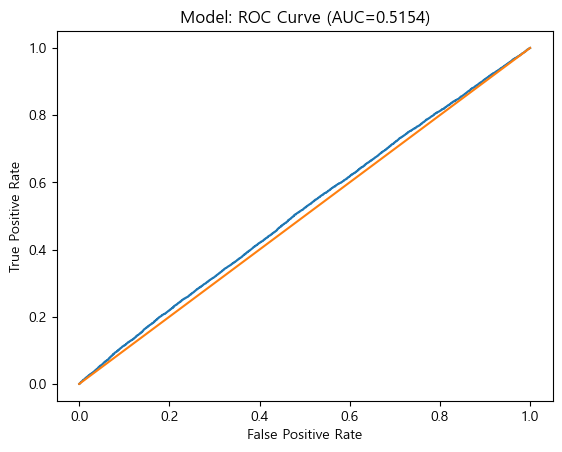

In [ ]:
# 4) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Model: ROC Curve (AUC={auc:.4f})")
plt.show()

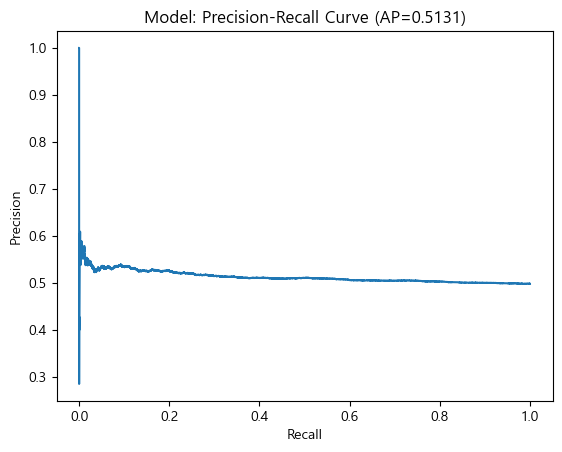

In [ ]:
# 5) PR Curve
prec, rec, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Model: Precision-Recall Curve (AP={ap:.4f})")
plt.show()


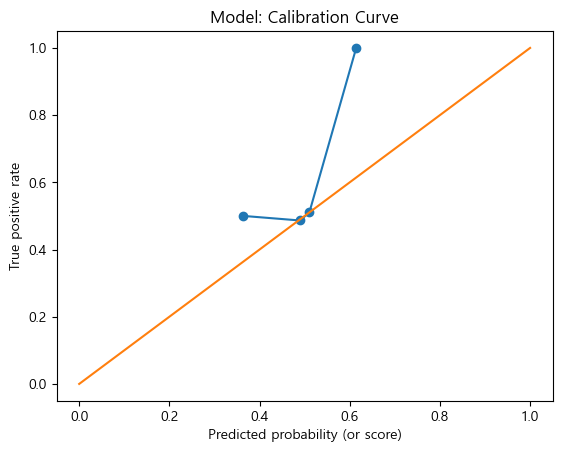

In [ ]:
# 6) Calibration curve 
prob_true, prob_pred = calibration_curve(y_test, y_score, n_bins=10, strategy="uniform")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1])
plt.xlabel("Predicted probability (or score)")
plt.ylabel("True positive rate")
plt.title("Model: Calibration Curve")
plt.show()